In [1]:
# import tensorflow as tf
# import numpy as np
# import pandas as pd
# import os
# from tensorflow.keras.layers import Rescaling

import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

Load the training and testing data, rescale all pixels to be float vals within 0-1

In [2]:
import os
import pandas as pd

data_dir = './archive'

# Define train and test directories
training_directory = os.path.join(data_dir, 'train')
testing_directory = os.path.join(data_dir, 'test')

print(training_directory)


# Get train images
train_real_images = [os.path.join(training_directory, 'REAL', img) for img in os.listdir(os.path.join(training_directory, 'REAL'))]
train_fake_images = [os.path.join(training_directory, 'FAKE', img) for img in os.listdir(os.path.join(training_directory, 'FAKE'))]

# Get test images
test_real_images = [os.path.join(testing_directory, 'REAL', img) for img in os.listdir(os.path.join(testing_directory, 'REAL'))]
test_fake_images = [os.path.join(testing_directory, 'FAKE', img) for img in os.listdir(os.path.join(testing_directory, 'FAKE'))]


# print(test_real_images[0])
# (0, 1) = (fake, real)

real_df = pd.DataFrame({'image_path': train_real_images + test_real_images,
                        'label': ["1"]*len(train_real_images) + ["1"]*len(test_real_images)}) ##60 thousand real, 0 fake

fake_df = pd.DataFrame({'image_path': train_fake_images + test_fake_images,
                        'label': ["0"]*len(train_fake_images) + ["0"]*len(test_fake_images)}) #0 real, 60 thousand fake

# real_df.head(), fake_df.head()


# Sample 80% of the rows from each DataFrame
rTrain = real_df.sample(frac=0.8, replace=False)
fTrain = fake_df.sample(frac=0.8, replace=False)

train_df = pd.concat([rTrain, fTrain])

#drops sampled from DFs
real_df = real_df.drop(rTrain.index)
fake_df = fake_df.drop(fTrain.index)

print(len(train_df)) #96,000

test_df = pd.concat([real_df, fake_df])
print(len(test_df)) ## 24,000

print(np.shape(train_df['image_path']))

print(sum(train_df['label'] == "1"))

./archive/train
96000
24000
(96000,)
48000


Now have the testing and training sets of images, need to convert images into numpy arrays to resize and greyscale them.

num of images = 96000


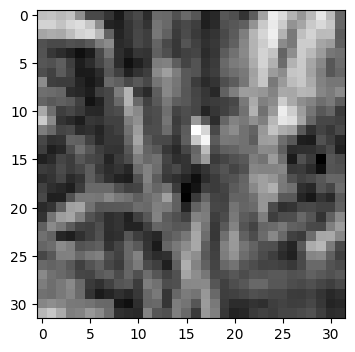

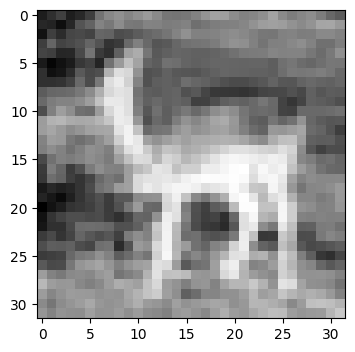

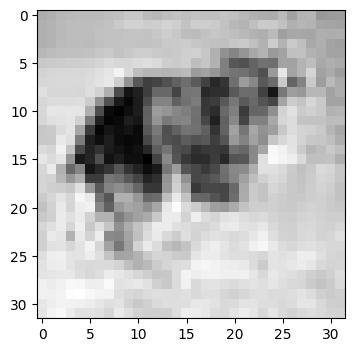

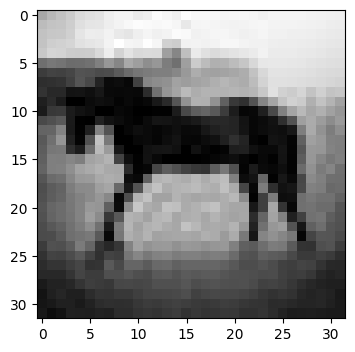

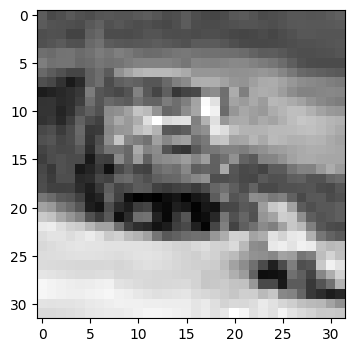

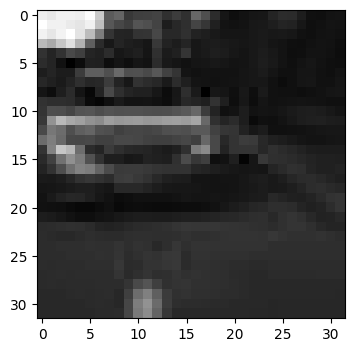

----------------- On to test images -------------------
num of images = 24000


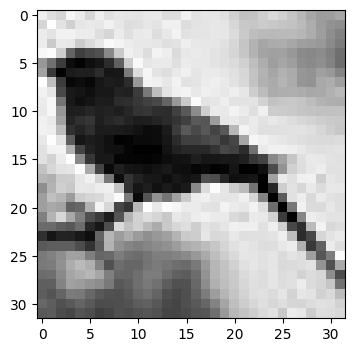

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
# test_df.head()

imgNum = 0
training_images = []
print(f"num of images = {len(train_df)}")
for filename in train_df["image_path"]:
    # print(filename)
    
    imgNum += 1
    image = plt.imread(filename)
    image = np.dot(
        image[..., :3], [0.299, 0.587, 0.114] )  #From HW3: convert 3D RGB array into 2D grayscale array (32x32)
    if ((imgNum % 15000) == 0): ## arbitrarily set to not show every image
        fig = plt.figure(figsize=(4, 4))
        plt.imshow(image, cmap="gray")
        plt.show()
    training_images.append(image.flatten())  # Flatten into a 1D vector


faces = np.array(training_images)
# print(np.shape(faces))

print("----------------- On to test images -------------------")
imgNum = 0
testing_images = []
print(f"num of images = {len(test_df)}")
for filename in test_df["image_path"]:
    # print(filename)
    imgNum += 1
    image = plt.imread(filename)
    image = np.dot(
        image[..., :3], [0.299, 0.587, 0.114] )  #From HW3: convert 3D RGB array into 2D grayscale array (32x32)
    if ((imgNum % 15000) == 0): ## arbitrarily set to not show every image
        fig = plt.figure(figsize=(4, 4))
        plt.imshow(image, cmap="gray")
        plt.show()
    testing_images.append(image.flatten())  # Flatten into a 1D vector

faces = np.array(testing_images)
# print(np.shape(faces))

Run SVD on our images matrix, centered.

In [4]:
import numpy as np
rowMeans = np.mean(training_images, axis=0)
centered_images = training_images - rowMeans # center
U, S, V = np.linalg.svd(centered_images, full_matrices=False)

print(f"U dims =  {np.shape(U)}") #(96000, 1024)
print(f"S dims = {np.shape(S)}") #(1024,)
print(f"V dims = {np.shape(V)}") #(1024, 1024)

U dims =  (96000, 1024)
S dims = (1024,)
V dims = (1024, 1024)


Similar to HW implementation for PCA, meant to evaluate the num of features needed to retain variance >= retained_variance.
This num of features will be represented by the returned collumn number of X_new

In [5]:
def transform_rv(data, S, V, retained_variance):
	"""_summary_

	Args:
		data: images/any dataset we are working with
		S: S matrix from SVD on this matrix
		V: V matrix from SVD on this matrix
		retained_variance: variance level that we want to retain while miminizing # of features

	Returns:
		_type_: _description_
	"""
	eigenvalues = S ** 2
	total_variance = np.sum(eigenvalues)
	explained_variance_ratio = eigenvalues / total_variance
	cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

	K = np.searchsorted(cumulative_variance_ratio, retained_variance) + 1

	rowMeans = np.mean(data, axis=0)
	data -= rowMeans
	X_new = np.dot(data, V[:K].T)
	return X_new

Use PCA to find number dimensions needed that would retain x amount of variance

I want to store all of the numpy matrices connected to variance retention levels in a dict.

ex. If I want to access the matrix that minimizes features while retaining 70% variance, I can get it at PCA_rv_percents[rv=.70]

In [6]:
training_PCA_rv_percents = {} # empties/initializes this dict, dont run this unless more than once unless u want to empty the dict
testing_PCA_rv_percents = {}


In [7]:
# used to add compressed arrays related to retention levels to the dictionary
def add_retained_var_vals(start, stop):
    i = start
    while i <= stop:
        dictstring = f"rv=.{i}" # set key for dictionary
        training_PCA_rv_percents[dictstring] = transform_rv(training_images, S, V, (i/100)) # 
        i += 1


Populate the dict in pieces, we probably wouldn't use the lower vals

In [8]:
add_retained_var_vals(25, 50)
add_retained_var_vals(76, 85)
add_retained_var_vals(51, 75)
add_retained_var_vals(86, 100)

In [9]:
print(f"Number of entries in dict: {len(training_PCA_rv_percents)}") # 76 if theyre all ran

def display_dims_rv(num):
    key = f"rv=.{num}"
    shape = np.shape(training_PCA_rv_percents[key])
    print(f"num of features needed to retain {num}% variance: {shape[1]}")
    
def add_train_labels(dic, labels):
    for k, v in dic.items():
        dic[k] = np.append(dic[k], labels, axis = 1)

    

Number of entries in dict: 76


In [13]:
display_dims_rv(100)
display_dims_rv(99)
display_dims_rv(98)
display_dims_rv(97)
display_dims_rv(96)
display_dims_rv(95)
display_dims_rv(94)
display_dims_rv(93)
display_dims_rv(92)
display_dims_rv(91)
display_dims_rv(90)

display_dims_rv(80)
display_dims_rv(70)
display_dims_rv(60)
display_dims_rv(50)
display_dims_rv(40)

add_train_labels(training_PCA_rv_percents, train_df["label"].to_numpy().reshape(-1, 1)) # add corresponding labels to the end of the PCA computed numpy array

num of features needed to retain 100% variance: 1024
num of features needed to retain 99% variance: 508
num of features needed to retain 98% variance: 373
num of features needed to retain 97% variance: 294
num of features needed to retain 96% variance: 240
num of features needed to retain 95% variance: 201
num of features needed to retain 94% variance: 172
num of features needed to retain 93% variance: 148
num of features needed to retain 92% variance: 129
num of features needed to retain 91% variance: 114
num of features needed to retain 90% variance: 101
num of features needed to retain 80% variance: 39
num of features needed to retain 70% variance: 19
num of features needed to retain 60% variance: 11
num of features needed to retain 50% variance: 7
num of features needed to retain 40% variance: 5


In [ ]:
print(np.shape(training_PCA_rv_percents["rv=.90"])) # will be (96000, num of features + 1)

# i want to get the best K features of the testing dataset, where k is the dims frim the training set


(96000, 101)


Now that I have all of the choices for condensed training features, I want to use that to get the K best features from testing dataset.

In [ ]:
import numpy as np
rowMeans = np.mean(testing_images, axis=0)
centered_images = testing_images - rowMeans # center
tU, tS, tV = np.linalg.svd(centered_images, full_matrices=False)

print(f"U dims =  {np.shape(U)}") #(96000, 1024)
print(f"S dims = {np.shape(S)}") #(1024,)
print(f"V dims = {np.shape(V)}") #(1024, 1024)

def transform(data, V, K):
    rowMeans = np.mean(data, axis=0)
    data -= rowMeans
    X_new = np.dot(data, V[:K].T)
    return X_new

U dims =  (96000, 1024)
S dims = (1024,)
V dims = (1024, 1024)


In [ ]:
## to find number of features, use np.shape(your training array - 1)[1] for the columns. Subtract 1 to account for the label column that is currently added to the train set
condensed_testing = transform(testing_images, tV, np.shape(training_PCA_rv_percents["rv=.90"])[1] - 1)
print(np.shape(condensed_testing)) # now add the test labels right?
test_labels = test_df["label"].to_numpy().reshape(-1, 1)
condensed_testing = np.append(condensed_testing, test_labels, axis = 1)
print(np.shape(condensed_testing))

(24000, 100)
(24000, 101)
